# Beam shape reconstruction

In [3]:
import numpy as np
import matplotlib.pylab as plt

In [4]:
# Fonction d'interpolation
def phi(x):
    phi = np.piecewise(x, [x <= -1,
                     (x > -1)&(x<0),
                     (x >= 0)&(x < 1),
                      x >= 1],
                    [0,
                     lambda x: x+1,
                     lambda x: -x+1,
                     0])
    return phi

def Phi(x):
    Phi = np.piecewise(x, [x <= -1,
                     (x > -1)&(x<0),
                     (x >= 0)&(x < 1),
                      x >= 1],
                    [0,
                     lambda x: .5*(x+1)**2,
                     lambda x: -.5*(x-1)**2 + 1,
                     1])
    return Phi

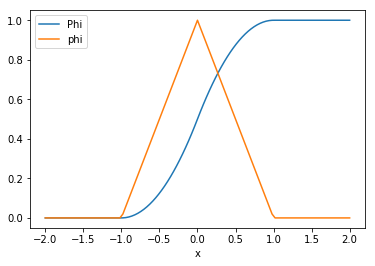

In [6]:
x = np.linspace(-2, 2, 103)
plt.plot(x, Phi(x), label='Phi');
plt.plot(x, phi(x), label='phi');
plt.xlabel('x'); plt.legend();

In [34]:
acceptance = 0.27 *np.pi/180  # demi angle
L = 100 # mm
h = 0.2 # mm, plate thickness
gap = L*np.tan(acceptance)
gap

0.4712423862755803

In [82]:
L = 100 # mm, length of the plates
gap = .47 #mm, gap between plates
plate = .2 # mm, thickness

R = 340 # mm, gonio center to plates distance
z0 = .01

beam_width = 2.4 # mm, overestimation of the beam footprint

geom = L, gap, plate, R

In [458]:
def intervalles(theta, geom, z0=0):
    L, gap, plate, R = geom
    
    theta = np.abs( np.asarray(theta) )
    
    shadow = L*np.sin(theta) + plate*np.cos(theta)
    period = (gap + plate)*np.cos(theta)
    through = (period - shadow).clip(0, period)
    
    offset = theta*R + z0
    return period, through, offset

def through_start_end(theta, geom, z0=0):
    ''' altitude du début et de la fin de la zone passante pour la lumière
        relativement au millieu de l'épaisseur de la lame solide
    '''
    L, gap, plate, R = geom
    
    theta =  np.asarray(theta) 
    
    #shadow = L*np.sin(theta) + plate*np.cos(theta)
    period = (gap + plate)*np.cos(theta)
    #through = (period - shadow).clip(0, period)
    if np.abs(np.tan(theta)) >= gap/L:
        return period, 0, 0, 0
    elif theta>0:
        through_start = plate/2*np.cos(theta) + L*np.sin(theta)
        through_end = period - plate/2*np.cos(theta) 
    else:
        through_start = plate/2*np.cos(theta) 
        through_end = period - plate/2*np.cos(theta) + L*np.sin(theta)
        
    offset = theta*R + z0
    return period, through_start, through_end, offset

In [351]:
intervalles(-.0004, geom)

(0.5699999544000005, 0.429999963466667, 0.136)

In [459]:
def Aij(theta, k, i_max, dz, z0, geom):

    period, start_through, end_through, offset = through_start_end(theta, geom, z0=0)
    
    i_range = np.arange(-i_max, +i_max+1)
    slit_starts = i_range*period + offset + start_through + offset
    slit_ends = i_range*period + offset + end_through + offset

    
    return np.sum(  Phi(slit_ends/dz - k)\
                  - Phi(slit_starts/dz - k))*dz

def build_A(theta_range, k_range, i_max, dz, z0, geom):
    A_mat = np.zeros((len(theta_range), len(k_range)))
    for i, theta in enumerate(theta_range):
        for j, k in enumerate(k_range):
            A_mat[i, j] = Aij(theta, k, i_max, dz, z0, geom)
    return A_mat

In [460]:
i_max = np.ceil(beam_width/2/(gap+plate)) + 10

dz = .03
z0 = 0

k_max = 10
k_range = np.arange(-k_max, +k_max+1)
theta_range = np.linspace(-.04, .04, 20)

dz = theta_range.ptp()/len(theta_range) * R

A_mat = build_A(theta_range, k_range, i_max, dz, z0)

plt.pcolor(k_range, theta_range, A_mat); plt.colorbar();
plt.xlabel('k'); plt.ylabel('theta');

TypeError: build_A() missing 1 required positional argument: 'geom'

## Data exp

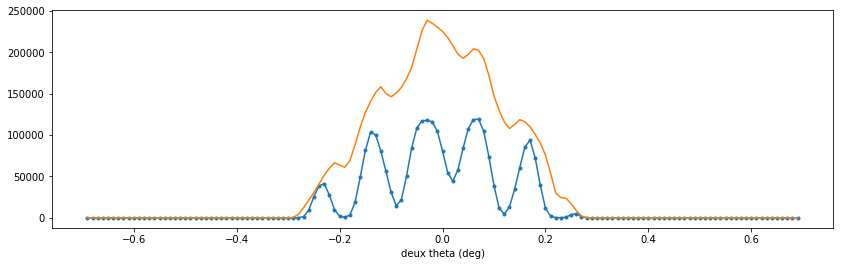

In [461]:
repertoire = 'data_calibration_diff/'
data = np.genfromtxt(repertoire+'FaisceauDirect_deuxTheta_fente200um_att90.csv',
                     skip_header=33, delimiter=',')
deux_theta, I_200um = data[:, 0], data[:, 1]

data = np.genfromtxt(repertoire+'FaisceauDirect_deuxTheta_fente500um_att90.csv',
                     skip_header=33, delimiter=',')
deux_theta, I_500um = data[:, 0], data[:, 1]

plt.figure(figsize=(14, 4))
plt.plot(deux_theta, I_200um, '.-');
plt.plot(deux_theta, I_500um);
plt.xlabel('deux theta (deg)');

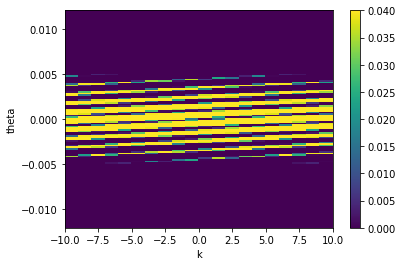

In [472]:
L = 95 # mm, length of the plates
gap = .47 #mm, gap between plates
plate = .09 # mm, thickness
R = 260 # mm, gonio center to plates distance

geom = L, gap, plate, R

i_max = 19

z0 = 0

k_max = 10
k_range = np.arange(-k_max, +k_max+1)
theta_range = deux_theta *np.pi/180

dz = 0.04

A_mat = build_A(theta_range, k_range, i_max, dz, z0, geom)

plt.pcolor(k_range, theta_range, A_mat); plt.colorbar();
plt.xlabel('k'); plt.ylabel('theta');

In [473]:
print(dz*k_max)

0.4


(139, 21)


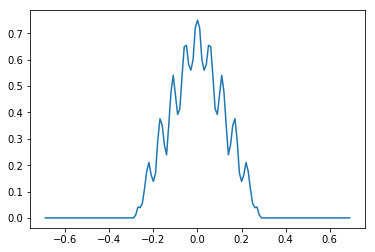

In [474]:
plt.plot(deux_theta, A_mat.sum(axis=1));
print(A_mat.shape)

In [475]:
x = np.linalg.lstsq(A_mat, I_200um, rcond=None)[0]
x

array([-2.27165207e+09, -8.15681857e+09,  8.76656119e+09, -6.45293595e+09,
        7.27681614e+09, -4.56380936e+09, -4.16362903e+08,  6.06728403e+04,
        3.70615530e+05,  1.24303302e+05,  3.39985010e+05, -9.72973945e+04,
        5.34232694e+05, -2.51630887e+05,  2.27294833e+09,  8.15575742e+09,
       -8.76550839e+09,  6.45293414e+09, -7.27688162e+09,  4.56455613e+09,
        4.16224253e+08])

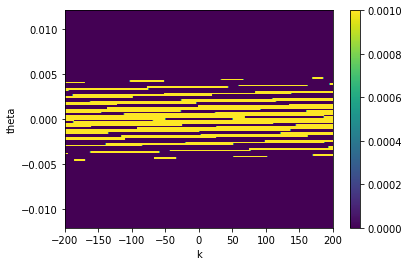

In [476]:
# Forward:
L = 100 # mm, length of the plates
gap = .47 #mm, gap between plates
plate = .1 # mm, thickness
R = 340 # mm, gonio center to plates distance

geom = L, gap, plate, R

i_max = 19

z0 = 0 # offset

k_max = 200
k_range = np.arange(-k_max, +k_max+1)

dz = 0.001

theta_range = deux_theta *np.pi/180
A_mat = build_A(theta_range, k_range, i_max, dz, z0, geom)

plt.pcolor(k_range, theta_range, A_mat); plt.colorbar();
plt.xlabel('k'); plt.ylabel('theta');

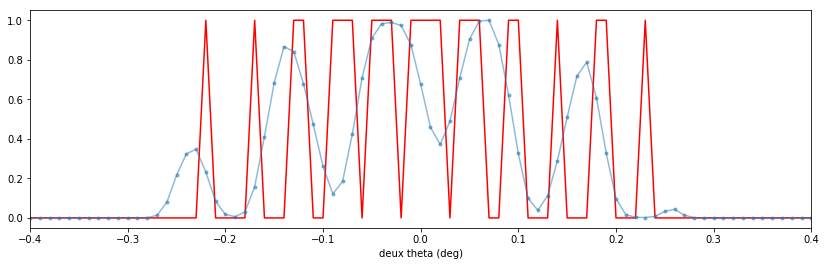

In [477]:
#k_range = np.arange(-k_max, +k_max+1)

beam = np.zeros_like(k_range, dtype=float)
beam[np.abs(dz*k_range+0.3)<0.10] = 1

x = np.matmul( A_mat, beam )

plt.figure(figsize=(14, 4));
plt.plot(deux_theta, x/x.max(), 'r');
plt.plot(deux_theta, I_200um/I_200um.max(), '.-', alpha=0.5);
plt.xlabel('deux theta (deg)');  plt.xlim((-0.4, 0.4));

In [421]:
beam

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [402]:
z_range = theta_range * R

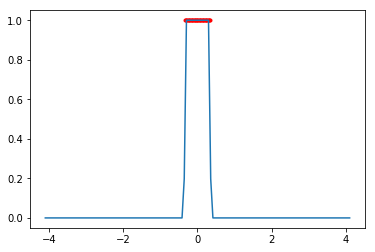

In [403]:
sol = np.zeros_like(z_range, dtype=float)
for k, Bk in zip(k_range, x):
    sol += Bk*phi(z_range/dz - k)
    plt.plot(k*dz, Bk, '.r')
plt.plot(z_range, sol);

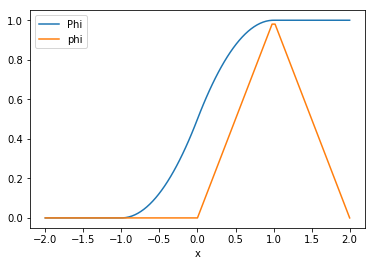

In [201]:
x = np.linspace(-2, 2, 103)
plt.plot(x, Phi(x), label='Phi');
plt.plot(x, phi(x-1), label='phi');
plt.xlabel('x'); plt.legend();

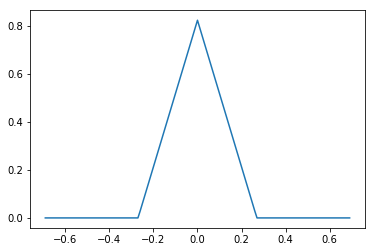

In [346]:
# Verif. transmittance

L = 100 # mm, length of the plates
gap = .47 #mm, gap between plates
plate = .1 # mm, thickness
R = 340 # mm, gonio center to plates distance

geom = L, gap, plate, R

period, through, offset = intervalles(deux_theta *np.pi/180, geom, z0=0)

transmittance = through / period

plt.plot(deux_theta, transmittance);

In [213]:
# Verif interpolation

In [263]:
z_range = np.linspace(-3, 3, 121)
dz = 1.5

k_max = 5
k_range = np.arange(-k_max, +k_max+1)

x = np.zeros_like(k_range, dtype=float)

In [264]:
x[k_range==0] = 1
x[k_range==1] = 1.5

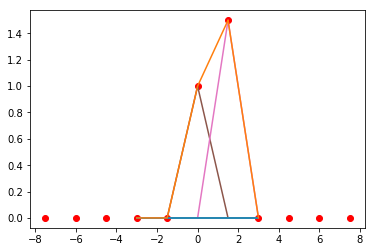

In [265]:
sol = np.zeros_like(z_range)
for k, Bk in zip(k_range, x):
    sol += Bk*phi(z_range/dz - k)
    plt.plot(k*dz, Bk, 'or')
    plt.plot(z_range, Bk*phi(z_range/dz - k));
plt.plot(z_range, sol);

In [258]:
x

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0])

In [435]:
# overlap

In [457]:
beam_start = -1
beam_end = 1

slit_start, slit_end = 1, 0

diff = np.minimum(beam_end, slit_end) - np.maximum(slit_start, beam_start)
overlap = np.maximum(diff, 0)

print(overlap)

0
